reference: 

[Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import os

In [2]:
cwd = os.getcwd()
f_d = '/data/DATA_CME_S1_22012021.csv'

# data

In [3]:
d = pd.read_csv(cwd+f_d)

In [4]:
d.head()

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
0,2021-01-21,1369.00,1387.00,1365.50,1367.50,0.75,1370.25,108662.0,358270.0
1,2021-01-20,1384.50,1384.50,1352.00,1368.75,-16.25,1369.50,171018.0,366235.0
2,2021-01-19,1419.00,1421.25,1383.25,1385.00,-31.00,1385.75,121099.0,374876.0
3,2021-01-15,1432.25,1434.50,1413.50,1424.75,-13.75,1416.75,95665.0,378606.0
4,2021-01-14,1413.00,1413.00,1413.00,1411.75,25.50,1436.50,12.0,52.0


## subset the data since 2010-01-01

In [5]:
df = d[['Date', 'Settle']]
df.loc[:,'Date'] = pd.to_datetime(df.loc[:,'Date'])
df = df[df.loc[:,'Date'] >= '2010-01-01']

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [6]:
df.head()

,Date,Settle
0,2021-01-21,1370.25
1,2021-01-20,1369.50
2,2021-01-19,1385.75
3,2021-01-15,1416.75
4,2021-01-14,1436.50


In [7]:
df.tail()

,Date,Settle
2781,2010-01-08,1013.00
2782,2010-01-07,1017.75
2783,2010-01-06,1050.50
2784,2010-01-05,1052.25
2785,2010-01-04,1049.50


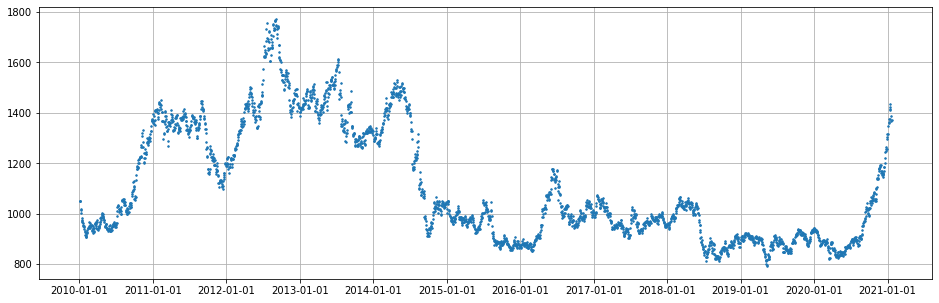

In [8]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(16, 5))
plt.plot_date(x=df.Date, y=df.Settle, ms=1.5)
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.grid()

## convert the TS to supervised ML dataset

reference: 

[How to Convert a Time Series to a Supervised Learning Problem in Python](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

In [12]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations (oldest first) as a list or NumPy array;
              NOTE: the order of the list is .
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is np.ndarray or list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
df.sort_values(by='Date', ascending=True).tail()

,Date,Settle
4,2021-01-14,1436.50
3,2021-01-15,1416.75
2,2021-01-19,1385.75
1,2021-01-20,1369.50
0,2021-01-21,1370.25


In [14]:
values = df.sort_values(by='Date', ascending=True)['Settle'].values

In [15]:
values[:10]

array([1049.5 , 1052.25, 1050.5 , 1017.75, 1013.  , 1001.75,  969.5 ,
        983.5 ,  968.5 ,  974.  ])

## normalize the data

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values.reshape(-1, 1))

In [18]:
scaled[:10]

array([[0.26377551],
       [0.26658163],
       [0.26479592],
       [0.23137755],
       [0.22653061],
       [0.21505102],
       [0.18214286],
       [0.19642857],
       [0.18112245],
       [0.18673469]])

In [83]:
N_IN = 7
N_OUT = 1

In [84]:
reshaped = series_to_supervised(scaled, n_in=N_IN, n_out=N_OUT, dropnan=True)

In [85]:
reshaped.index = df.sort_values(by='Date', ascending=True)['Date'][N_IN:]

In [86]:
reshaped.tail()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
Date,,,,,,,,
2021-01-14,0.570408,0.585969,0.581122,0.596684,0.595408,0.643878,0.632653,0.658673
2021-01-15,0.585969,0.581122,0.596684,0.595408,0.643878,0.632653,0.658673,0.638520
2021-01-19,0.581122,0.596684,0.595408,0.643878,0.632653,0.658673,0.638520,0.606888
2021-01-20,0.596684,0.595408,0.643878,0.632653,0.658673,0.638520,0.606888,0.590306
2021-01-21,0.595408,0.643878,0.632653,0.658673,0.638520,0.606888,0.590306,0.591071


## training/test data split

In [87]:
reshaped.loc[reshaped.index >= '2020-01-01'].shape[0]

266

In [88]:
# split into train and test sets
train = reshaped.loc[reshaped.index < '2020-01-01']
test = reshaped.loc[reshaped.index >= '2020-01-01']

In [89]:
# split into input and outputs
train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

> Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features]

In [90]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.values.reshape((train_X.shape[0], N_OUT, train_X.shape[1]))
test_X = test_X.values.reshape((test_X.shape[0], N_OUT, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2513, 1, 7) (2513,) (266, 1, 7) (266,)


# model

## design network

In [91]:
import tensorflow as tf

In [92]:
# design network

EPOCHS = 100
BATCH_SIZE = 77
TRAIN_SPLIT = 0.87
LOSS_FUNCTION = 'mse' # 'mse': Mean Square Error, 'mae': Mean Absolute Error, 'binary_crossentropy'
LEARNING_RATE = 0.001 #0.001
NEURONS = 128

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(NEURONS, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, name='lstm1'))
model.add(tf.keras.layers.LSTM(NEURONS, name='lstm2'))
model.add(tf.keras.layers.Dense(1, activation='relu', name='output'))
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss=LOSS_FUNCTION, optimizer=optimizer)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 1, 128)            69632     
_________________________________________________________________
lstm2 (LSTM)                 (None, 128)               131584    
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 201,345
Trainable params: 201,345
Non-trainable params: 0
_________________________________________________________________


## train the model

In [93]:
# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False)

Epoch 1/100
30/30 [==============================] - 3s 25ms/step - loss: 0.1314 - val_loss: 0.0155
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0029
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 5.0102e-04
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 3.6650e-04
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 3.8739e-04
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 3.7698e-04
Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 3.5146e-04
Epoch 9/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 3.2989e-04
Epoch 10/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0015 - v

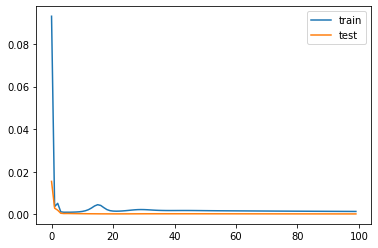

In [94]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## prediction

In [95]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], N_OUT*test_X.shape[2]))

## invert scaling for forcast and actual

In [96]:
inv_yhat = scaler.inverse_transform(yhat)

In [97]:
inv_yhat = inv_yhat.reshape(1, len(inv_yhat))

In [98]:
inv_y = scaler.inverse_transform(np.array(test_y).reshape(1, len(test_y)))

In [99]:
result = pd.DataFrame()
result['settle'] = inv_y.tolist()[0]
result['prediction'] = inv_yhat.tolist()[0]
result.index = test_y.index
result.head()

,settle,prediction
Date,,
2020-01-02,944.25,927.095154
2020-01-03,930.50,929.631470
2020-01-06,932.75,926.445190
2020-01-07,935.00,924.582031
2020-01-08,938.25,924.252136


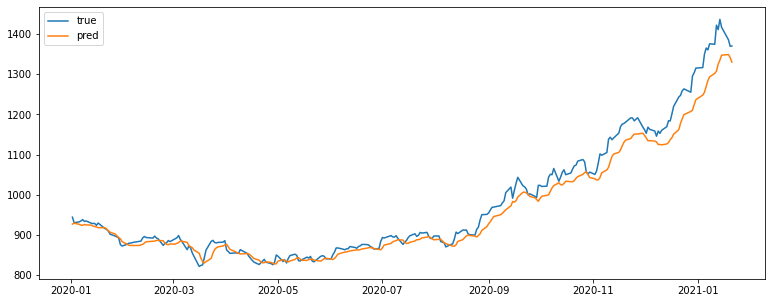

In [100]:
# Make the plotting-canvas bigger.
plt.figure(figsize=(13,5))

# Plot and compare the two signals.
plt.plot(result['settle'], label='true')
plt.plot(result['prediction'], label='pred')

# Plot labels etc.
plt.legend()
plt.show()

In [101]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 30.542
